In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7205821a64c0>)

In [3]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [46]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'+'image2.jpg'
background_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'+'volcano.jpg'

(960, 540)


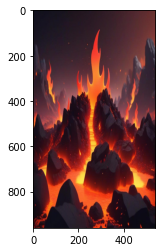

In [77]:
img_orig = cv2.imread(img_path)
img_shape = img_orig.shape[:2]
print(img_shape)
background_orig = cv2.imread(background_img_path)
background_orig = cv2.resize(background_orig, img_shape[::-1])

plt.imshow(cv2.cvtColor(background_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [78]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

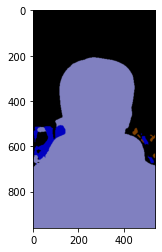

In [79]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

(960, 540)


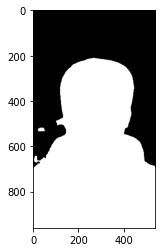

In [80]:
seg_color = (128,128,192)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

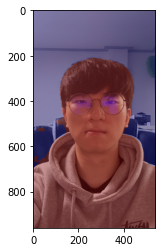

In [81]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

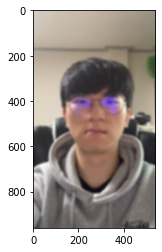

In [82]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

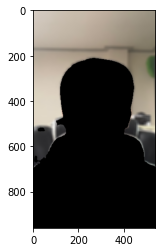

In [83]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

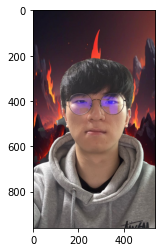

In [84]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, background_orig)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [123]:
def make_model():
    # 모델을 return하는 함수
    model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

    # PixelLib가 제공하는 모델의 url입니다
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

    # 다운로드를 시작합니다
    urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장
    
    model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
    model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
    
    return model

In [102]:
def find_colormap(class_id):
    # class_id에 따른 색상 맵을 반환하는 함수
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    return colormap[class_id]

In [118]:
def make_blur(img, size=13):
    # 블러 처리를 수행하는 함수
    return cv2.blur(img, (size,size))

In [124]:
def make_background(model, img_path, background, cat_mode=False):
    # 배경 처리를 수행하는 함수
    # 모델, 이미지 경로, 배경 이미지, 고양이 모드 여부를 인자로 받음
    img = cv2.imread(img_path)
    
    img_shape = img.shape[:2]
    # resize는 size를 (width, height)순으로 받음
    background = cv2.resize(background, (img_shape[1],img_shape[0]))
    
    segvalues, output = model.segmentAsPascalvoc(img_path)

    # colormap이 BGR 순으로 반환되기 때문에 역순으로 반환
    if cat_mode:
        seg_color = find_colormap(8)[::-1].tolist()
    else:
        seg_color = find_colormap(15)[::-1].tolist()

    # 세그멘테이션 마스크를 생성
    seg_map = np.all(output==seg_color, axis=-1) 
    
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255
    
    # 세그멘테이션 마스크를 색상 맵으로 변환
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    # 아래 두 줄의 코드는 배경에서 사람을 제외한 부분을 추출하는 코드
    # 그런데 이후 합치는 부분에서 세그멘테이션 마스크에 따라 사람 부분은
    # 사용하지 않기 때문에 필요 없는 코드인 것 같음.
    # 배경 마스크를 생성
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    # 배경 마스크를 이용하여 배경을 추출
    background = cv2.bitwise_and(background, img_bg_mask)
    
    # 배경과 사람을 합치기
    img_concat = np.where(img_mask_color==255, img, background)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

In [125]:
my_model = make_model()

[128, 128, 192]


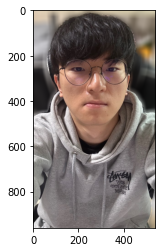

[128, 128, 192]


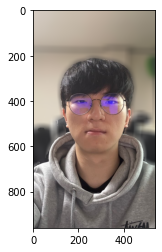

[128, 128, 192]


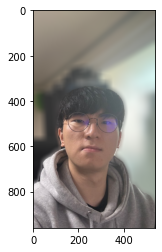

In [126]:
img_paths = [os.getenv('HOME')+'/aiffel/human_segmentation/images/'+img_name+'.jpg' 
             for img_name in ['image1','image2','image3']]
for img_path in img_paths:
    background_img = make_blur(cv2.imread(img_path), size=33)
    make_background(my_model, img_path, background_img)

[0, 0, 64]


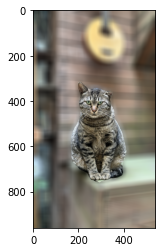

In [127]:
img_paths = [os.getenv('HOME')+'/aiffel/human_segmentation/images/'+img_name+'.jpg' 
             for img_name in ['cat']]
for img_path in img_paths:
    background_img = make_blur(cv2.imread(img_path), size=33)
    make_background(my_model, img_path, background_img, cat_mode=True)

[128, 128, 192]


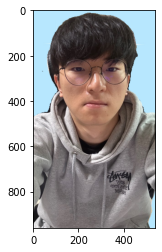

[128, 128, 192]


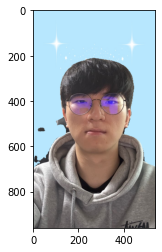

[128, 128, 192]


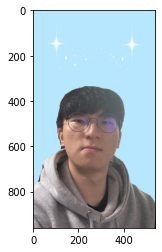

In [129]:
img_paths = [os.getenv('HOME')+'/aiffel/human_segmentation/images/'+img_name+'.jpg' 
             for img_name in ['image1', 'image2', 'image3']]
background_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'+'skyblue.jpg'
background_img = cv2.imread(background_img_path)
for img_path in img_paths:
    make_background(my_model, img_path, background_img)

### 제작한 인물모드 사진들에서 나타나는 문제점
![](images/error_image.png)
- segmentaion이 정확하게 이루어지지 않고, 목 뒤의 의자나 배경이 사람으로 인식된 모습이다.

![](images/error_image2.png)
- 위와 같이, segmentation이 잘 이루어지지 않아, 여러 경계면에서 배경이 사람으로 인식되었다.

### 인물모드 사진의 문제점을 개선할 수 있는 솔루션
![](images/flowchart.png)
1. Segmentation 모델의 성능을 높일 수 있는가?
    - 만약 그렇다면, 높은 성능의 segmentation 모델로 더 정확한 mask를 만들어 아웃포커싱이 더 높은 정확도로 적용될 것이다.
2. 사진을 촬영할 때, 초점을 수동으로 지정하거나 자동으로 계산할 수 있는가?
    - depth 정보가 명확하다면, 동일한 depth에 대해 같은 mask를 지정하는 방식을 통해 segmentation 효과를 낼 수 있기 때문에 아웃포커싱에 도움이 될 것이다.
3. SW나 다른 기술등을 사용해 이미지의 깊이를 측정할 수 있는가?
    - 위와 같이, depth 정보가 명확하다면 mask를 지정하여 segmentation을 수행할 수 있다.